# Description

A simple character-level RNN to generate new bits of text


# Reading and preprocessing text

First we will read the text from the file and remove portions from the beginning and the end (these contain certain descriptions of the Gutenberg project).

In [1]:

 ## Reading and processing text
with open('preprocessed_dataset.txt', 'r', encoding="utf8") as fp: smiles=fp.read()

smile_set = set(smiles)

In [2]:
import numpy as np

text = smiles
char_set = smile_set  # removes duplicates -> get unique characters

In [3]:
print(f"Text Length: {len(text)}")
print(f"Unique characters: {len(char_set)}")

Text Length: 5547397
Unique characters: 31


Now we need to convert this data to numeric format. To do this, we will create a simple Python dictionary that maps each character to an integer. We will also need a reverse mapping to convert the results of our model back to text.

In [4]:
chars_sorted = sorted(char_set)
char2int = {ch:i for i,ch in enumerate(chars_sorted)}
# int2chr = {i:ch for i,ch in enumerate(chars_sorted)}
char_array = np.array(chars_sorted) # more efficient than dict

In [8]:
text_encoded = np.array([char2int[ch] for ch in text], dtype=np.int32)
print("Text encoded shape: ", text_encoded.shape)
print(f"{text[:21]} == Encoding ==> {text_encoded[:21]}")
print(text_encoded[:21], "== Reverse ==>", "".join(char_array[text_encoded[:21]]))

Text encoded shape:  (5547397,)
CC[C@H]1C[C@@H](OC(=O == Encoding ==> [14 14 21 14 12 16 23  7 14 21 14 12 12 16 23  2 19 14  2 11 19]
[14 14 21 14 12 16 23  7 14 21 14 12 12 16 23  2 19 14  2 11 19] == Reverse ==> CC[C@H]1C[C@@H](OC(=O


For the text generation task, we can formulate the problem as a classification task. Since we have 85 unique characters, it becomes a *multiclass* classification task

We will clip the sequence length to 40. Longer length is better, but RNN will have problems capturing *long-range* dependencies. Sequence length is a hyperparameter optimization porblem, which we have to evaluate empirically.

In [9]:
import torch
from torch.utils.data import Dataset

We will split text into chunks of size 41. The first 40 character will form input sequence *x*, and the last 40 will form the taregt sequence *y* (since target is just offset by 1).

In [10]:
seq_length = 40 # hyperparameter
chunk_size = seq_length + 1
text_chunks = [text_encoded[i:i+chunk_size] for i in range(len(text_encoded) - chunk_size+1)]

In [11]:
class TextDataset(Dataset):
    def __init__(self, text_chunks):
        self.text_chunks = text_chunks

    def __len__(self):
        return len(self.text_chunks)

    def __getitem__(self, idx):
        text_chunk = self.text_chunks[idx]
        return text_chunk[:-1], text_chunk[1:].long()

In [10]:
seq_dataset = TextDataset(torch.tensor(text_chunks))

for i, (seq, target) in enumerate(seq_dataset):
    print("Input (x): ", repr("".join(char_array[seq])))
    print("Target (y): ", repr("".join(char_array[target])))
    print()
    if i == 1: 
        break

Input (x):  'CC[C@H]1C[C@@H](OC(=O)COc2ccc([N+](=O)[O'
Target (y):  'C[C@H]1C[C@@H](OC(=O)COc2ccc([N+](=O)[O-'

Input (x):  'C[C@H]1C[C@@H](OC(=O)COc2ccc([N+](=O)[O-'
Target (y):  '[C@H]1C[C@@H](OC(=O)COc2ccc([N+](=O)[O-]'



/var/folders/fp/n6tyvsqs38bcnkzxj_x61ctw0000gn/T/ipykernel_27516/3452713142.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  seq_dataset = TextDataset(torch.tensor(text_chunks))


In [11]:
# Transform into minibatches
from torch.utils.data import DataLoader
batch_size = 64
torch.manual_seed(1)
seq_dl = DataLoader(seq_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

The `drop_last` argument drops the last non-full batch of each worker’s iterable-style dataset replica i.e. the `drop_last=True` parameter ignores the last batch (when the number of examples in your dataset is not divisible by your `batch_size`) while `drop_last=False` will make the last batch smaller than your `batch_size`.

# Building a character-level RNN model

In [12]:
import torch.nn as nn
class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size):
        super().__init__()
        self.rnn_hidden_size = rnn_hidden_size
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.LSTM(embed_dim, rnn_hidden_size, batch_first=True)
        self.fc = nn.Linear(rnn_hidden_size, vocab_size)

    def forward(self, x, hidden, cell):
        out = self.embedding(x).unsqueeze(1)
        out, (hidden, cell) = self.rnn(out, (hidden, cell))
        out = self.fc(out).reshape(out.size(0), -1)
        return out, hidden, cell

    def init_hidden(self, batch_size):
        hidden = torch.zeros(1, batch_size, self.rnn_hidden_size)
        cell = torch.zeros(1, batch_size, self.rnn_hidden_size)
        return hidden, cell

We are taking `logits` as output so that we can sample from the model predictions in order to generate new text.

In [13]:
# Create RNN model
vocab_size = len(char_array)
embed_dim = 256
rnn_hidden_size = 512
torch.manual_seed(1)
model = RNN(vocab_size, embed_dim, rnn_hidden_size)
model

RNN(
  (embedding): Embedding(31, 256)
  (rnn): LSTM(256, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=31, bias=True)
)

# Train the model

In [16]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

/Users/sefunmibodun/anaconda3/envs/dami/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

In [17]:
from tqdm import tqdm


num_epochs = 2000
torch.manual_seed(1)

model.to(device)
for epoch in tqdm(range(num_epochs)):
    model.train()
    hidden, cell = model.init_hidden(batch_size)
    hidden, cell = hidden.to(device), cell.to(device)
    seq_batch, target_batch = next(iter(seq_dl))
    seq_batch, target_batch = seq_batch.to(device), target_batch.to(device)
    optimizer.zero_grad()
    loss = 0
    for c in range(seq_length):
        pred, hidden, cell = model(seq_batch[:, c], hidden, cell)
        loss += loss_fn(pred, target_batch[:, c])
    loss.backward()
    optimizer.step()
    loss = loss.item() / seq_length
    if epoch % 20 == 0:
        print(f"Epoch {epoch} loss: {loss:.4f}")

  0%|                                        | 1/2000 [00:02<1:21:53,  2.46s/it]

Epoch 0 loss: 3.4536


  1%|▍                                        | 21/2000 [00:07<08:12,  4.02it/s]

Epoch 20 loss: 0.9224


  2%|▊                                        | 41/2000 [00:12<08:05,  4.04it/s]

Epoch 40 loss: 0.7789


  3%|█▎                                       | 61/2000 [00:17<07:53,  4.09it/s]

Epoch 60 loss: 0.7210


  4%|█▋                                       | 81/2000 [00:22<07:59,  4.00it/s]

Epoch 80 loss: 0.7187


  5%|██                                      | 101/2000 [00:27<07:47,  4.06it/s]

Epoch 100 loss: 0.7317


  6%|██▍                                     | 121/2000 [00:32<07:49,  4.00it/s]

Epoch 120 loss: 0.7131


  7%|██▊                                     | 141/2000 [00:37<07:34,  4.09it/s]

Epoch 140 loss: 0.6484


  8%|███▏                                    | 161/2000 [00:42<07:32,  4.06it/s]

Epoch 160 loss: 0.6539


  9%|███▌                                    | 181/2000 [00:47<07:42,  3.93it/s]

Epoch 180 loss: 0.6586


 10%|████                                    | 201/2000 [00:52<07:50,  3.82it/s]

Epoch 200 loss: 0.6130


 11%|████▍                                   | 221/2000 [00:57<07:37,  3.89it/s]

Epoch 220 loss: 0.6058


 12%|████▊                                   | 241/2000 [01:02<07:39,  3.83it/s]

Epoch 240 loss: 0.6643


 13%|█████▏                                  | 261/2000 [01:08<07:38,  3.79it/s]

Epoch 260 loss: 0.6348


 14%|█████▌                                  | 281/2000 [01:13<07:30,  3.81it/s]

Epoch 280 loss: 0.6415


 15%|██████                                  | 301/2000 [01:18<07:34,  3.74it/s]

Epoch 300 loss: 0.6259


 16%|██████▍                                 | 321/2000 [01:24<07:33,  3.70it/s]

Epoch 320 loss: 0.6166


 17%|██████▊                                 | 341/2000 [01:29<07:25,  3.72it/s]

Epoch 340 loss: 0.5888


 18%|███████▏                                | 361/2000 [01:35<07:41,  3.55it/s]

Epoch 360 loss: 0.6343


 19%|███████▌                                | 381/2000 [01:40<07:19,  3.68it/s]

Epoch 380 loss: 0.6164


 20%|████████                                | 401/2000 [01:45<07:14,  3.68it/s]

Epoch 400 loss: 0.5828


 21%|████████▍                               | 421/2000 [01:51<07:15,  3.62it/s]

Epoch 420 loss: 0.6136


 22%|████████▊                               | 441/2000 [01:56<07:10,  3.62it/s]

Epoch 440 loss: 0.6036


 23%|█████████▏                              | 461/2000 [02:02<07:08,  3.59it/s]

Epoch 460 loss: 0.6386


 24%|█████████▌                              | 481/2000 [02:08<07:18,  3.47it/s]

Epoch 480 loss: 0.6019


 25%|██████████                              | 501/2000 [02:14<07:01,  3.55it/s]

Epoch 500 loss: 0.6082


 26%|██████████▍                             | 521/2000 [02:20<07:01,  3.51it/s]

Epoch 520 loss: 0.6070


 27%|██████████▊                             | 541/2000 [02:25<06:46,  3.59it/s]

Epoch 540 loss: 0.6127


 28%|███████████▏                            | 561/2000 [02:31<06:56,  3.45it/s]

Epoch 560 loss: 0.5870


 29%|███████████▌                            | 581/2000 [02:36<06:36,  3.58it/s]

Epoch 580 loss: 0.5577


 30%|████████████                            | 601/2000 [02:42<06:30,  3.58it/s]

Epoch 600 loss: 0.6345


 31%|████████████▍                           | 621/2000 [02:48<06:29,  3.54it/s]

Epoch 620 loss: 0.5995


 32%|████████████▊                           | 641/2000 [02:53<06:25,  3.53it/s]

Epoch 640 loss: 0.5646


 33%|█████████████▏                          | 661/2000 [02:59<06:16,  3.56it/s]

Epoch 660 loss: 0.5562


 34%|█████████████▌                          | 681/2000 [03:05<06:07,  3.58it/s]

Epoch 680 loss: 0.5846


 35%|██████████████                          | 701/2000 [03:10<06:12,  3.49it/s]

Epoch 700 loss: 0.5877


 36%|██████████████▍                         | 721/2000 [03:16<06:02,  3.52it/s]

Epoch 720 loss: 0.5925


 37%|██████████████▊                         | 741/2000 [03:22<05:55,  3.54it/s]

Epoch 740 loss: 0.5687


 38%|███████████████▏                        | 761/2000 [03:27<05:47,  3.57it/s]

Epoch 760 loss: 0.5867


 39%|███████████████▌                        | 781/2000 [03:33<05:47,  3.51it/s]

Epoch 780 loss: 0.5734


 40%|████████████████                        | 801/2000 [03:39<05:37,  3.55it/s]

Epoch 800 loss: 0.5990


 41%|████████████████▍                       | 821/2000 [03:44<05:41,  3.45it/s]

Epoch 820 loss: 0.5792


 42%|████████████████▊                       | 841/2000 [03:50<05:27,  3.54it/s]

Epoch 840 loss: 0.5740


 43%|█████████████████▏                      | 861/2000 [03:56<05:21,  3.54it/s]

Epoch 860 loss: 0.5869


 44%|█████████████████▌                      | 881/2000 [04:01<05:20,  3.49it/s]

Epoch 880 loss: 0.5650


 45%|██████████████████                      | 901/2000 [04:07<05:17,  3.46it/s]

Epoch 900 loss: 0.5516


 46%|██████████████████▍                     | 921/2000 [04:13<05:02,  3.57it/s]

Epoch 920 loss: 0.5278


 47%|██████████████████▊                     | 941/2000 [04:18<04:59,  3.53it/s]

Epoch 940 loss: 0.5545


 48%|███████████████████▏                    | 961/2000 [04:24<05:04,  3.41it/s]

Epoch 960 loss: 0.5676


 49%|███████████████████▌                    | 981/2000 [04:30<05:01,  3.38it/s]

Epoch 980 loss: 0.5674


 50%|███████████████████▌                   | 1001/2000 [04:36<05:00,  3.33it/s]

Epoch 1000 loss: 0.5764


 51%|███████████████████▉                   | 1021/2000 [04:42<05:00,  3.26it/s]

Epoch 1020 loss: 0.5438


 52%|████████████████████▎                  | 1041/2000 [04:49<04:58,  3.21it/s]

Epoch 1040 loss: 0.5607


 53%|████████████████████▋                  | 1061/2000 [04:55<05:03,  3.10it/s]

Epoch 1060 loss: 0.5761


 54%|█████████████████████                  | 1081/2000 [05:02<05:00,  3.06it/s]

Epoch 1080 loss: 0.5644


 55%|█████████████████████▍                 | 1101/2000 [05:08<05:01,  2.98it/s]

Epoch 1100 loss: 0.5684


 56%|█████████████████████▊                 | 1121/2000 [05:15<05:11,  2.83it/s]

Epoch 1120 loss: 0.5650


 57%|██████████████████████▏                | 1141/2000 [05:22<04:55,  2.91it/s]

Epoch 1140 loss: 0.5245


 58%|██████████████████████▋                | 1161/2000 [05:29<04:56,  2.83it/s]

Epoch 1160 loss: 0.5377


 59%|███████████████████████                | 1181/2000 [05:36<04:52,  2.80it/s]

Epoch 1180 loss: 0.5683


 60%|███████████████████████▍               | 1201/2000 [05:43<04:45,  2.80it/s]

Epoch 1200 loss: 0.5706


 61%|███████████████████████▊               | 1221/2000 [05:51<04:44,  2.74it/s]

Epoch 1220 loss: 0.5567


 62%|████████████████████████▏              | 1241/2000 [05:58<04:40,  2.70it/s]

Epoch 1240 loss: 0.5670


 63%|████████████████████████▌              | 1261/2000 [06:06<04:44,  2.60it/s]

Epoch 1260 loss: 0.5304


 64%|████████████████████████▉              | 1281/2000 [06:14<05:20,  2.24it/s]

Epoch 1280 loss: 0.5573


 65%|█████████████████████████▎             | 1301/2000 [06:24<07:32,  1.55it/s]

Epoch 1300 loss: 0.5621


 66%|█████████████████████████▊             | 1321/2000 [06:35<06:29,  1.74it/s]

Epoch 1320 loss: 0.5249


 67%|██████████████████████████▏            | 1341/2000 [06:44<04:51,  2.26it/s]

Epoch 1340 loss: 0.5461


 68%|██████████████████████████▌            | 1361/2000 [06:53<04:27,  2.39it/s]

Epoch 1360 loss: 0.5359


 69%|██████████████████████████▉            | 1381/2000 [07:03<04:46,  2.16it/s]

Epoch 1380 loss: 0.5481


 70%|███████████████████████████▎           | 1401/2000 [07:13<04:22,  2.28it/s]

Epoch 1400 loss: 0.5509


 71%|███████████████████████████▋           | 1421/2000 [07:23<04:18,  2.24it/s]

Epoch 1420 loss: 0.5376


 72%|████████████████████████████           | 1441/2000 [07:34<04:36,  2.02it/s]

Epoch 1440 loss: 0.5512


 73%|████████████████████████████▍          | 1461/2000 [07:42<03:41,  2.44it/s]

Epoch 1460 loss: 0.5398


 74%|████████████████████████████▉          | 1481/2000 [07:51<03:47,  2.29it/s]

Epoch 1480 loss: 0.5687


 75%|█████████████████████████████▎         | 1501/2000 [07:59<03:28,  2.40it/s]

Epoch 1500 loss: 0.5302


 76%|█████████████████████████████▋         | 1521/2000 [08:08<03:19,  2.40it/s]

Epoch 1520 loss: 0.5646


 77%|██████████████████████████████         | 1541/2000 [08:17<03:23,  2.25it/s]

Epoch 1540 loss: 0.5400


 78%|██████████████████████████████▍        | 1561/2000 [08:25<03:10,  2.31it/s]

Epoch 1560 loss: 0.5178


 79%|██████████████████████████████▊        | 1581/2000 [08:35<03:10,  2.19it/s]

Epoch 1580 loss: 0.5583


 80%|███████████████████████████████▏       | 1601/2000 [08:45<03:55,  1.70it/s]

Epoch 1600 loss: 0.5255


 81%|███████████████████████████████▌       | 1621/2000 [08:54<03:23,  1.86it/s]

Epoch 1620 loss: 0.5423


 82%|███████████████████████████████▉       | 1641/2000 [09:04<02:45,  2.17it/s]

Epoch 1640 loss: 0.5369


 83%|████████████████████████████████▍      | 1661/2000 [09:14<02:57,  1.91it/s]

Epoch 1660 loss: 0.5250


 84%|████████████████████████████████▊      | 1681/2000 [09:25<03:46,  1.41it/s]

Epoch 1680 loss: 0.5376


 85%|█████████████████████████████████▏     | 1701/2000 [09:35<02:20,  2.13it/s]

Epoch 1700 loss: 0.5565


 86%|█████████████████████████████████▌     | 1721/2000 [09:44<02:15,  2.07it/s]

Epoch 1720 loss: 0.5251


 87%|█████████████████████████████████▉     | 1741/2000 [09:54<02:00,  2.16it/s]

Epoch 1740 loss: 0.5386


 88%|██████████████████████████████████▎    | 1761/2000 [10:03<01:51,  2.15it/s]

Epoch 1760 loss: 0.5409


 89%|██████████████████████████████████▋    | 1781/2000 [10:13<01:42,  2.13it/s]

Epoch 1780 loss: 0.5371


 90%|███████████████████████████████████    | 1801/2000 [10:23<01:42,  1.95it/s]

Epoch 1800 loss: 0.5495


 91%|███████████████████████████████████▌   | 1821/2000 [10:33<01:28,  2.03it/s]

Epoch 1820 loss: 0.5356


 92%|███████████████████████████████████▉   | 1841/2000 [10:42<01:15,  2.11it/s]

Epoch 1840 loss: 0.5198


 93%|████████████████████████████████████▎  | 1861/2000 [10:53<01:10,  1.98it/s]

Epoch 1860 loss: 0.5734


 94%|████████████████████████████████████▋  | 1881/2000 [11:04<01:05,  1.81it/s]

Epoch 1880 loss: 0.5493


 95%|█████████████████████████████████████  | 1901/2000 [11:16<00:59,  1.66it/s]

Epoch 1900 loss: 0.5270


 96%|█████████████████████████████████████▍ | 1921/2000 [11:28<00:46,  1.70it/s]

Epoch 1920 loss: 0.5181


 97%|█████████████████████████████████████▊ | 1941/2000 [11:39<00:32,  1.84it/s]

Epoch 1940 loss: 0.5169


 98%|██████████████████████████████████████▏| 1961/2000 [11:52<00:26,  1.46it/s]

Epoch 1960 loss: 0.5629


 99%|██████████████████████████████████████▋| 1981/2000 [12:03<00:10,  1.87it/s]

Epoch 1980 loss: 0.5303


100%|███████████████████████████████████████| 2000/2000 [12:13<00:00,  2.73it/s]


In [18]:
torch.save(model.state_dict(), "./model.pt")

In [20]:
model.load_state_dict(torch.load("./model.pt"))

<All keys matched successfully>

In [30]:
model.to(device)

RNN(
  (embedding): Embedding(31, 256)
  (rnn): LSTM(256, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=31, bias=True)
)

# Evaluation phase - generating new text

The RNN model we trained in the previous section returnss the logits of size 85 for each unique character, which can be converted to probabilities via softmax. One simple way to generate text is to choose the character with the highest logit value. In other words, you pick the character that the model believes is the most likely next character based on its training.

However, always selecting the character with the highest likelihood can result in repetitive and less interesting text. To make the text more diverse and less predictable, it's better to randomly sample from the model's output probabilities. This means you don't always choose the character with the highest probability; you make a random choice based on the distribution of probabilities.

PyTorch already provides a class, `torch.distributions.categorical.Categorical`, which we can use to draw random samples from a categorical distribution.

In [41]:
from torch.distributions.categorical import Categorical
from tqdm import tqdm
device = "mps" if torch.backends.mps.is_available() else "cpu"

def sample(model, starting_str, max_length=100000, scale_factor=1.0):
    """
    starting_str: short starting string
    max_length: max length of generated text
    """

    encoded_input = torch.tensor([char2int[s] for s in starting_str])
    encoded_input = torch.reshape(encoded_input, (1, -1))
    generated_str = starting_str # initially set it equal to the input str

    model.eval()
    hidden, cell = model.init_hidden(batch_size=1)
    hidden = hidden.to(device)
    encoded_input = encoded_input.to(device)
    cell = cell.to(device)
    for c in range(len(starting_str)-1):
        _, hidden, cell = model(encoded_input[:, c].view(1), hidden, cell)
    last_char = encoded_input[:, -1]
    for i in tqdm(range(max_length)):
        logits, hidden, cell = model(last_char.view(1), hidden, cell)
        logits = torch.squeeze(logits, 0)
        scaled_logits = logits * scale_factor
        m = Categorical(logits=scaled_logits)
        last_char = m.sample()
        generated_str += str(char_array[last_char])

    return generated_str

In [42]:
import torch

if torch.backends.mps.is_available():
    torch.mps.empty_cache()


In [43]:
torch.manual_seed(1)
smiles = sample(model, starting_str="C")

100%|██████████████████████████████████| 100000/100000 [11:40<00:00, 142.74it/s]


In [44]:
list_of_smiles = []

for smiles in smiles.split("\n"):
    list_of_smiles.append(smiles)

In [45]:

from rdkit import Chem
valid_smiles = []

for smi in list_of_smiles:
    mol = Chem.MolFromSmiles(smi)
    if mol:
        valid_smiles.append(smi)
    else:
        pass
        #print(f"Invalid SMILES string: {smi}")



accuracy = (len(valid_smiles) / len(list_of_smiles) ) * 100
print(f"Accuracy = {len(valid_smiles)}/{len(list_of_smiles)} = {accuracy:.2f}")


[14:43:37] SMILES Parse Error: syntax error while parsing: C@H]1C[C@@H](O)CN[C@@H](C)c1ccc([N+](=O)[O-])cc1Cl
[14:43:37] SMILES Parse Error: Failed parsing SMILES 'C@H]1C[C@@H](O)CN[C@@H](C)c1ccc([N+](=O)[O-])cc1Cl' for input: 'C@H]1C[C@@H](O)CN[C@@H](C)c1ccc([N+](=O)[O-])cc1Cl'
[14:43:37] SMILES Parse Error: extra open parentheses for input: 'CCOC(=O)c1ccc(N[C@@H](c2ccc([N+](=O)[O-])cc2)n1'
[14:43:37] SMILES Parse Error: extra close parentheses while parsing: CCN(CCNc1ccccc1)(CC(=O)O)C(=O)O)c1cccc([N+](=O)[O-])c1)C1CCOCC1
[14:43:37] SMILES Parse Error: Failed parsing SMILES 'CCN(CCNc1ccccc1)(CC(=O)O)C(=O)O)c1cccc([N+](=O)[O-])c1)C1CCOCC1' for input: 'CCN(CCNc1ccccc1)(CC(=O)O)C(=O)O)c1cccc([N+](=O)[O-])c1)C1CCOCC1'
[14:43:37] SMILES Parse Error: extra close parentheses while parsing: CCn1nc(C)c(C(=O)NC/C=C/CNc2ccccc2)C1)c1ccccc1[N+](=O)[O-]
[14:43:37] SMILES Parse Error: Failed parsing SMILES 'CCn1nc(C)c(C(=O)NC/C=C/CNc2ccccc2)C1)c1ccccc1[N+](=O)[O-]' for input: 'CCn1nc(C)c(C(=O)NC/C=C

Accuracy = 811/1911 = 42.44


[14:43:37] SMILES Parse Error: extra open parentheses for input: 'CC(C)Oc1nc(N[C@H]2C[C@H](N(C)Cc2ccccc2)c1[N+](=O)[O-]'
[14:43:37] Can't kekulize mol.  Unkekulized atoms: 11 12 13
[14:43:37] SMILES Parse Error: ring closure 1 duplicates bond between atom 2 and atom 19 for input: 'CCC1(C(=O)NCCNc2ccc([N+](=O)[O-])c(C)c2)c1C'
[14:43:37] SMILES Parse Error: unclosed ring for input: 'CC[C@H]1CN(C[C@H](O)Cn2ccc3cccc([N+](=O)[O-])c2)c1=O'
[14:43:37] SMILES Parse Error: extra close parentheses while parsing: CCN(CCc1ccccc1)C(=O)Cn1ncc2C(=O)OCc3cccc([N+](=O)[O-])cc23)C1
[14:43:37] SMILES Parse Error: Failed parsing SMILES 'CCN(CCc1ccccc1)C(=O)Cn1ncc2C(=O)OCc3cccc([N+](=O)[O-])cc23)C1' for input: 'CCN(CCc1ccccc1)C(=O)Cn1ncc2C(=O)OCc3cccc([N+](=O)[O-])cc23)C1'
[14:43:37] Can't kekulize mol.  Unkekulized atoms: 10 11 12 17 18
[14:43:37] Can't kekulize mol.  Unkekulized atoms: 3 4 5
[14:43:37] SMILES Parse Error: extra open parentheses for input: 'CCn1cc(C(=O)NCCN(C(=O)c2cc(OC)cc([N+](=O)[O-])c2)

In [46]:
len(valid_smiles)

811

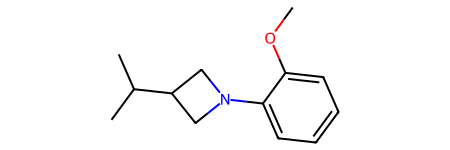

In [54]:
Chem.MolFromSmiles(valid_smiles[131])

# Finetuning

In [12]:

 ## Reading and processing text
with open('eg5/preprocessed_eg5.txt', 'r', encoding="utf8") as fp: eg5=fp.read()



In [13]:
eg5_encoded = np.array([char2int[ch] for ch in eg5], dtype=np.int32)
print("Eg5 encoded shape: ", eg5_encoded.shape)
print(f"{eg5[:21]} == Encoding ==> {eg5_encoded[:21]}")
print(eg5_encoded[:21], "== Reverse ==>", "".join(char_array[eg5_encoded[:21]]))

Eg5 encoded shape:  (23266,)
CC(=O)Nc1ccc([C@@H]2N == Encoding ==> [14 14  2 11 19  3 18 24  7 24 24 24  2 21 14 12 12 16 23  8 18]
[14 14  2 11 19  3 18 24  7 24 24 24  2 21 14 12 12 16 23  8 18] == Reverse ==> CC(=O)Nc1ccc([C@@H]2N


In [14]:
seq_length = 40 # hyperparameter
chunk_size = seq_length + 1
eg5_chunks = [eg5_encoded[i:i+chunk_size] for i in range(len(eg5_encoded) - chunk_size+1)]

In [15]:
class TextDataset(Dataset):
    def __init__(self, text_chunks):
        self.text_chunks = text_chunks

    def __len__(self):
        return len(self.text_chunks)

    def __getitem__(self, idx):
        text_chunk = self.text_chunks[idx]
        return text_chunk[:-1], text_chunk[1:].long()

In [16]:
eg5_dataset = TextDataset(torch.tensor(eg5_chunks))

for i, (seq, target) in enumerate(eg5_dataset):
    print("Input (x): ", repr("".join(char_array[seq])))
    print("Target (y): ", repr("".join(char_array[target])))
    print()
    if i == 1: 
        break

Input (x):  'CC(=O)Nc1ccc([C@@H]2Nc3ccc(C(C)(C)C)cc3['
Target (y):  'C(=O)Nc1ccc([C@@H]2Nc3ccc(C(C)(C)C)cc3[C'

Input (x):  'C(=O)Nc1ccc([C@@H]2Nc3ccc(C(C)(C)C)cc3[C'
Target (y):  '(=O)Nc1ccc([C@@H]2Nc3ccc(C(C)(C)C)cc3[C@'



/var/folders/fp/n6tyvsqs38bcnkzxj_x61ctw0000gn/T/ipykernel_29959/553595255.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  eg5_dataset = TextDataset(torch.tensor(eg5_chunks))


In [17]:
# Transform into minibatches
from torch.utils.data import DataLoader
batch_size = 64
torch.manual_seed(1)
eg5_dl = DataLoader(eg5_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [18]:
import torch.nn as nn
class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size):
        super().__init__()
        self.rnn_hidden_size = rnn_hidden_size
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.LSTM(embed_dim, rnn_hidden_size, batch_first=True)
        self.fc = nn.Linear(rnn_hidden_size, vocab_size)

    def forward(self, x, hidden, cell):
        out = self.embedding(x).unsqueeze(1)
        out, (hidden, cell) = self.rnn(out, (hidden, cell))
        out = self.fc(out).reshape(out.size(0), -1)
        return out, hidden, cell

    def init_hidden(self, batch_size):
        hidden = torch.zeros(1, batch_size, self.rnn_hidden_size)
        cell = torch.zeros(1, batch_size, self.rnn_hidden_size)
        return hidden, cell

In [19]:
# Create RNN model
vocab_size = len(char_array)
embed_dim = 256
rnn_hidden_size = 512
torch.manual_seed(1)
finetunemodel = RNN(vocab_size, embed_dim, rnn_hidden_size)
finetunemodel

RNN(
  (embedding): Embedding(31, 256)
  (rnn): LSTM(256, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=31, bias=True)
)

In [20]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(finetunemodel.parameters(), lr=0.001)

/Users/sefunmibodun/anaconda3/envs/dami/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [124]:
from tqdm import tqdm
finetunemodel.load_state_dict(torch.load('./model.pt'))

<All keys matched successfully>

In [126]:


num_epochs = 2000
torch.manual_seed(1)

finetunemodel.to(device)
for epoch in tqdm(range(num_epochs)):
    finetunemodel.train()
    hidden, cell = finetunemodel.init_hidden(batch_size)
    hidden, cell = hidden.to(device), cell.to(device)
    seq_batch, target_batch = next(iter(eg5_dl))
    seq_batch, target_batch = seq_batch.to(device), target_batch.to(device)
    optimizer.zero_grad()
    loss = 0
    for c in range(seq_length):
        pred, hidden, cell = finetunemodel(seq_batch[:, c], hidden, cell)
        loss += loss_fn(pred, target_batch[:, c])
    loss.backward()
    optimizer.step()
    loss = loss.item() / seq_length
    if epoch % 20 == 0:
        print(f"Epoch {epoch} loss: {loss:.4f}")

  0%|                                          | 3/2000 [00:00<06:13,  5.35it/s]

Epoch 0 loss: 1.3046


  1%|▍                                        | 23/2000 [00:02<02:45, 11.95it/s]

Epoch 20 loss: 0.6479


  2%|▉                                        | 43/2000 [00:03<02:40, 12.18it/s]

Epoch 40 loss: 0.5191


  3%|█▎                                       | 63/2000 [00:05<02:38, 12.21it/s]

Epoch 60 loss: 0.4289


  4%|█▋                                       | 83/2000 [00:07<02:36, 12.25it/s]

Epoch 80 loss: 0.4534


  5%|██                                      | 103/2000 [00:08<02:35, 12.20it/s]

Epoch 100 loss: 0.3902


  6%|██▍                                     | 123/2000 [00:10<02:33, 12.26it/s]

Epoch 120 loss: 0.3877


  7%|██▊                                     | 143/2000 [00:12<02:31, 12.27it/s]

Epoch 140 loss: 0.3512


  8%|███▎                                    | 163/2000 [00:13<02:29, 12.31it/s]

Epoch 160 loss: 0.3311


  9%|███▋                                    | 183/2000 [00:15<02:28, 12.20it/s]

Epoch 180 loss: 0.3306


 10%|████                                    | 203/2000 [00:17<02:27, 12.21it/s]

Epoch 200 loss: 0.3267


 11%|████▍                                   | 223/2000 [00:18<02:24, 12.28it/s]

Epoch 220 loss: 0.3178


 12%|████▊                                   | 243/2000 [00:20<02:23, 12.23it/s]

Epoch 240 loss: 0.3089


 13%|█████▎                                  | 263/2000 [00:22<02:23, 12.11it/s]

Epoch 260 loss: 0.3175


 14%|█████▋                                  | 283/2000 [00:23<02:21, 12.15it/s]

Epoch 280 loss: 0.2844


 15%|██████                                  | 303/2000 [00:25<02:18, 12.22it/s]

Epoch 300 loss: 0.2862


 16%|██████▍                                 | 323/2000 [00:27<02:16, 12.27it/s]

Epoch 320 loss: 0.2712


 17%|██████▊                                 | 343/2000 [00:28<02:15, 12.27it/s]

Epoch 340 loss: 0.2734


 18%|███████▎                                | 363/2000 [00:30<02:14, 12.19it/s]

Epoch 360 loss: 0.2927


 19%|███████▋                                | 383/2000 [00:31<02:11, 12.27it/s]

Epoch 380 loss: 0.2775


 20%|████████                                | 403/2000 [00:33<02:10, 12.20it/s]

Epoch 400 loss: 0.2539


 21%|████████▍                               | 423/2000 [00:35<02:09, 12.21it/s]

Epoch 420 loss: 0.2790


 22%|████████▊                               | 443/2000 [00:36<02:08, 12.15it/s]

Epoch 440 loss: 0.2681


 23%|█████████▎                              | 463/2000 [00:38<02:06, 12.12it/s]

Epoch 460 loss: 0.2692


 24%|█████████▋                              | 483/2000 [00:40<02:03, 12.26it/s]

Epoch 480 loss: 0.2560


 25%|██████████                              | 503/2000 [00:41<02:02, 12.24it/s]

Epoch 500 loss: 0.2638


 26%|██████████▍                             | 523/2000 [00:43<02:00, 12.25it/s]

Epoch 520 loss: 0.2524


 27%|██████████▊                             | 543/2000 [00:45<02:00, 12.12it/s]

Epoch 540 loss: 0.2538


 28%|███████████▎                            | 563/2000 [00:46<01:57, 12.25it/s]

Epoch 560 loss: 0.2533


 29%|███████████▋                            | 583/2000 [00:48<01:56, 12.16it/s]

Epoch 580 loss: 0.2597


 30%|████████████                            | 603/2000 [00:50<01:54, 12.18it/s]

Epoch 600 loss: 0.2458


 31%|████████████▍                           | 623/2000 [00:51<01:52, 12.22it/s]

Epoch 620 loss: 0.2487


 32%|████████████▊                           | 643/2000 [00:53<01:51, 12.18it/s]

Epoch 640 loss: 0.2577


 33%|█████████████▎                          | 663/2000 [00:54<01:49, 12.18it/s]

Epoch 660 loss: 0.2546


 34%|█████████████▋                          | 683/2000 [00:56<01:48, 12.19it/s]

Epoch 680 loss: 0.2555


 35%|██████████████                          | 703/2000 [00:58<01:46, 12.23it/s]

Epoch 700 loss: 0.2432


 36%|██████████████▍                         | 723/2000 [00:59<01:44, 12.21it/s]

Epoch 720 loss: 0.2569


 37%|██████████████▊                         | 743/2000 [01:01<01:42, 12.24it/s]

Epoch 740 loss: 0.2587


 38%|███████████████▎                        | 763/2000 [01:03<01:41, 12.23it/s]

Epoch 760 loss: 0.2505


 39%|███████████████▋                        | 783/2000 [01:04<01:39, 12.18it/s]

Epoch 780 loss: 0.2589


 40%|████████████████                        | 803/2000 [01:06<01:37, 12.26it/s]

Epoch 800 loss: 0.2484


 41%|████████████████▍                       | 823/2000 [01:08<01:36, 12.21it/s]

Epoch 820 loss: 0.2476


 42%|████████████████▊                       | 843/2000 [01:09<01:35, 12.17it/s]

Epoch 840 loss: 0.2481


 43%|█████████████████▎                      | 863/2000 [01:11<01:32, 12.23it/s]

Epoch 860 loss: 0.2326


 44%|█████████████████▋                      | 883/2000 [01:12<01:31, 12.26it/s]

Epoch 880 loss: 0.2340


 45%|██████████████████                      | 903/2000 [01:14<01:32, 11.86it/s]

Epoch 900 loss: 0.2404


 46%|██████████████████▍                     | 923/2000 [01:16<01:28, 12.16it/s]

Epoch 920 loss: 0.2362


 47%|██████████████████▊                     | 943/2000 [01:17<01:26, 12.19it/s]

Epoch 940 loss: 0.2418


 48%|███████████████████▎                    | 963/2000 [01:19<01:24, 12.23it/s]

Epoch 960 loss: 0.2374


 49%|███████████████████▋                    | 983/2000 [01:21<01:22, 12.29it/s]

Epoch 980 loss: 0.2311


 50%|███████████████████▌                   | 1003/2000 [01:22<01:21, 12.26it/s]

Epoch 1000 loss: 0.2343


 51%|███████████████████▉                   | 1023/2000 [01:24<01:19, 12.31it/s]

Epoch 1020 loss: 0.2280


 52%|████████████████████▎                  | 1043/2000 [01:26<01:17, 12.31it/s]

Epoch 1040 loss: 0.2211


 53%|████████████████████▋                  | 1063/2000 [01:27<01:16, 12.28it/s]

Epoch 1060 loss: 0.2375


 54%|█████████████████████                  | 1083/2000 [01:29<01:14, 12.24it/s]

Epoch 1080 loss: 0.2284


 55%|█████████████████████▌                 | 1103/2000 [01:30<01:13, 12.28it/s]

Epoch 1100 loss: 0.2381


 56%|█████████████████████▉                 | 1123/2000 [01:32<01:11, 12.32it/s]

Epoch 1120 loss: 0.2295


 57%|██████████████████████▎                | 1143/2000 [01:34<01:09, 12.32it/s]

Epoch 1140 loss: 0.2229


 58%|██████████████████████▋                | 1163/2000 [01:35<01:08, 12.28it/s]

Epoch 1160 loss: 0.2284


 59%|███████████████████████                | 1183/2000 [01:37<01:06, 12.30it/s]

Epoch 1180 loss: 0.2253


 60%|███████████████████████▍               | 1203/2000 [01:39<01:05, 12.23it/s]

Epoch 1200 loss: 0.2278


 61%|███████████████████████▊               | 1223/2000 [01:40<01:03, 12.30it/s]

Epoch 1220 loss: 0.2226


 62%|████████████████████████▏              | 1243/2000 [01:42<01:01, 12.24it/s]

Epoch 1240 loss: 0.2372


 63%|████████████████████████▋              | 1263/2000 [01:43<01:00, 12.21it/s]

Epoch 1260 loss: 0.2364


 64%|█████████████████████████              | 1283/2000 [01:45<00:58, 12.30it/s]

Epoch 1280 loss: 0.2264


 65%|█████████████████████████▍             | 1303/2000 [01:47<00:56, 12.28it/s]

Epoch 1300 loss: 0.2187


 66%|█████████████████████████▊             | 1323/2000 [01:48<00:55, 12.27it/s]

Epoch 1320 loss: 0.2305


 67%|██████████████████████████▏            | 1343/2000 [01:50<00:53, 12.18it/s]

Epoch 1340 loss: 0.2231


 68%|██████████████████████████▌            | 1363/2000 [01:52<00:51, 12.30it/s]

Epoch 1360 loss: 0.2152


 69%|██████████████████████████▉            | 1383/2000 [01:53<00:50, 12.24it/s]

Epoch 1380 loss: 0.2213


 70%|███████████████████████████▎           | 1403/2000 [01:55<00:48, 12.26it/s]

Epoch 1400 loss: 0.2262


 71%|███████████████████████████▋           | 1423/2000 [01:57<00:46, 12.30it/s]

Epoch 1420 loss: 0.2210


 72%|████████████████████████████▏          | 1443/2000 [01:58<00:46, 12.08it/s]

Epoch 1440 loss: 0.2239


 73%|████████████████████████████▌          | 1463/2000 [02:00<00:44, 12.11it/s]

Epoch 1460 loss: 0.2270


 74%|████████████████████████████▉          | 1483/2000 [02:02<00:42, 12.14it/s]

Epoch 1480 loss: 0.2183


 75%|█████████████████████████████▎         | 1503/2000 [02:03<00:40, 12.30it/s]

Epoch 1500 loss: 0.2160


 76%|█████████████████████████████▋         | 1523/2000 [02:05<00:38, 12.30it/s]

Epoch 1520 loss: 0.2335


 77%|██████████████████████████████         | 1543/2000 [02:07<00:36, 12.36it/s]

Epoch 1540 loss: 0.2230


 78%|██████████████████████████████▍        | 1563/2000 [02:08<00:35, 12.33it/s]

Epoch 1560 loss: 0.2186


 79%|██████████████████████████████▊        | 1583/2000 [02:10<00:34, 12.22it/s]

Epoch 1580 loss: 0.2232


 80%|███████████████████████████████▎       | 1603/2000 [02:12<00:34, 11.66it/s]

Epoch 1600 loss: 0.2177


 81%|███████████████████████████████▋       | 1623/2000 [02:13<00:30, 12.20it/s]

Epoch 1620 loss: 0.2194


 82%|████████████████████████████████       | 1643/2000 [02:15<00:29, 12.10it/s]

Epoch 1640 loss: 0.2226


 83%|████████████████████████████████▍      | 1663/2000 [02:17<00:27, 12.18it/s]

Epoch 1660 loss: 0.2339


 84%|████████████████████████████████▊      | 1683/2000 [02:18<00:25, 12.21it/s]

Epoch 1680 loss: 0.2099


 85%|█████████████████████████████████▏     | 1703/2000 [02:20<00:24, 12.28it/s]

Epoch 1700 loss: 0.2172


 86%|█████████████████████████████████▌     | 1723/2000 [02:21<00:22, 12.19it/s]

Epoch 1720 loss: 0.2027


 87%|█████████████████████████████████▉     | 1743/2000 [02:23<00:21, 12.20it/s]

Epoch 1740 loss: 0.2077


 88%|██████████████████████████████████▍    | 1763/2000 [02:25<00:19, 12.27it/s]

Epoch 1760 loss: 0.2157


 89%|██████████████████████████████████▊    | 1783/2000 [02:26<00:17, 12.19it/s]

Epoch 1780 loss: 0.2157


 90%|███████████████████████████████████▏   | 1803/2000 [02:28<00:16, 12.27it/s]

Epoch 1800 loss: 0.2185


 91%|███████████████████████████████████▌   | 1823/2000 [02:30<00:14, 12.21it/s]

Epoch 1820 loss: 0.2190


 92%|███████████████████████████████████▉   | 1843/2000 [02:31<00:12, 12.24it/s]

Epoch 1840 loss: 0.2137


 93%|████████████████████████████████████▎  | 1863/2000 [02:33<00:11, 12.23it/s]

Epoch 1860 loss: 0.2107


 94%|████████████████████████████████████▋  | 1883/2000 [02:35<00:09, 12.27it/s]

Epoch 1880 loss: 0.2101


 95%|█████████████████████████████████████  | 1903/2000 [02:36<00:07, 12.29it/s]

Epoch 1900 loss: 0.2088


 96%|█████████████████████████████████████▍ | 1923/2000 [02:38<00:06, 12.26it/s]

Epoch 1920 loss: 0.2131


 97%|█████████████████████████████████████▊ | 1941/2000 [02:39<00:04, 12.20it/s]

Epoch 1940 loss: 0.2169


 98%|██████████████████████████████████████▎| 1963/2000 [02:41<00:03, 12.29it/s]

Epoch 1960 loss: 0.2162


 99%|██████████████████████████████████████▋| 1983/2000 [02:43<00:01, 12.33it/s]

Epoch 1980 loss: 0.2234


100%|███████████████████████████████████████| 2000/2000 [02:44<00:00, 12.15it/s]


In [127]:
torch.save(finetunemodel.state_dict(), "finetunedmodel.pt")

# Generate compounds with fine tuned model

In [24]:
finetunemodel.load_state_dict(torch.load("finetunedmodel.pt"))
finetunemodel.to(device)

RNN(
  (embedding): Embedding(31, 256)
  (rnn): LSTM(256, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=31, bias=True)
)

In [27]:
from torch.distributions.categorical import Categorical
from tqdm import tqdm
device = "mps" if torch.backends.mps.is_available() else "cpu"

def sample(model, starting_str, max_length=300000, scale_factor=1.0):
    """
    starting_str: short starting string
    max_length: max length of generated text
    """

    encoded_input = torch.tensor([char2int[s] for s in starting_str])
    encoded_input = torch.reshape(encoded_input, (1, -1))
    generated_str = starting_str # initially set it equal to the input str

    model.eval()
    hidden, cell = model.init_hidden(batch_size=1)
    hidden = hidden.to(device)
    encoded_input = encoded_input.to(device)
    cell = cell.to(device)
    for c in range(len(starting_str)-1):
        _, hidden, cell = model(encoded_input[:, c].view(1), hidden, cell)
    last_char = encoded_input[:, -1]
    for i in tqdm(range(max_length)):
        logits, hidden, cell = model(last_char.view(1), hidden, cell)
        logits = torch.squeeze(logits, 0)
        scaled_logits = logits * scale_factor
        m = Categorical(logits=scaled_logits)
        last_char = m.sample()
        generated_str += str(char_array[last_char])

        if i %1000 == 0:
            torch.mps.empty_cache()


    return generated_str

In [28]:
torch.manual_seed(1)
finetunedsmiles = sample(finetunemodel, starting_str="C", scale_factor= 0.5)

100%|██████████████████████████████████| 300000/300000 [44:43<00:00, 111.80it/s]


In [29]:
list_of_smiles1 = []

for smiles in finetunedsmiles.split("\n"):
    list_of_smiles1.append(smiles)

In [41]:
from rdkit import RDLogger

# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')
from rdkit import Chem
valid_smiles1 = []

for smi in list_of_smiles1:
    mol = Chem.MolFromSmiles(smi)
    if mol:
        valid_smiles1.append(smi)
    else:
        pass
        #print(f"Invalid SMILES string: {smi}")



accuracy = (len(valid_smiles1) / len(list_of_smiles1) ) * 100
print(f"Accuracy = {len(valid_smiles1)}/{len(list_of_smiles1)} = {accuracy:.2f}")


Accuracy = 1180/6532 = 18.06


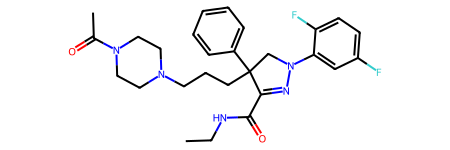

In [43]:
Chem.MolFromSmiles(valid_smiles1[1000])

In [44]:
# Load the training set from a text file
def load_training_set(file_path):
    with open(file_path, 'r') as file:
        training_smiles = set(line.strip() for line in file)
    return training_smiles

# Compare generated SMILES to the training set
def check_uniqueness(generated_smiles, training_smiles):
    unique_smiles = []
    for smiles in generated_smiles:
        if smiles not in training_smiles:
            unique_smiles.append(smiles)
    return unique_smiles

# Example usage
training_file_path = 'eg5/preprocessed_eg5.txt'
generated_smiles = valid_smiles1 # Replace with your generated SMILES

training_smiles_set = load_training_set(training_file_path)
unique_generated_smiles = check_uniqueness(generated_smiles, training_smiles_set)

print(f'Total generated SMILES: {len(generated_smiles)}')
print(f'Unique generated SMILES: {len(unique_generated_smiles)}')
#print('Unique SMILES:', unique_generated_smiles)


Total generated SMILES: 1180
Unique generated SMILES: 934


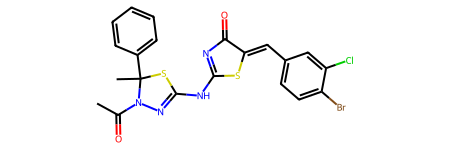

In [47]:
Chem.MolFromSmiles(unique_generated_smiles[800])

In [39]:
unique_generated_smiles[10]

'CCN1N=C(c2cc(F)ccc2F)CC1c1cccc(O)c1'

The model msotly generates correct words. In some cases, sentences might also make sense. Further tuning the training parameters and model architecture can improve the performance.

# Temperate

The `scale_factor` controls the randomness of the generated text. Low `scale_factor` (high temperature) results in more randomness because the output probability becomes more uniform, as opposed to more predictable behavior at high `scale_factor` (low temperature) where one logit will have high probability.

In [23]:
# Example
logits = torch.tensor([[1.0, 1.0, 3.0]])
print(f"Probabilities before scaling: {nn.functional.softmax(logits, dim=1).numpy()[0]}")
print(f"Probabilities after scaling with 0.5: {nn.functional.softmax(0.5 * logits, dim=1).numpy()[0]}")
print(f"Probabilities after scaling with 0.1: {nn.functional.softmax(0.1 * logits, dim=1).numpy()[0]}")
print(f"Probabilities after scaling with 3.0: {nn.functional.softmax(3.0 * logits, dim=1).numpy()[0]}")

Probabilities before scaling: [0.10650698 0.10650698 0.78698605]
Probabilities after scaling with 0.5: [0.21194156 0.21194156 0.57611686]
Probabilities after scaling with 0.1: [0.3104238  0.3104238  0.37915248]
Probabilities after scaling with 3.0: [0.00246652 0.00246652 0.9950669 ]


In [140]:
torch.manual_seed(1)
smiles = sample(finetunemodel, starting_str="C", scale_factor=2.0, max_length=1000)

100%|██████████████████████████████████████| 1000/1000 [00:06<00:00, 149.50it/s]


In [141]:
list_of_smiles = []

for smiles in smiles.split("\n"):
    list_of_smiles.append(smiles)

In [142]:

from rdkit import Chem
valid_smiles = []

for smi in list_of_smiles:
    mol = Chem.MolFromSmiles(smi)
    if mol:
        valid_smiles.append(smi)
    else:
        pass
        #print(f"Invalid SMILES string: {smi}")



accuracy = (len(valid_smiles) / len(list_of_smiles) ) * 100
print(f"Accuracy = {len(valid_smiles)}/{len(list_of_smiles)} = {accuracy:.2f}")


Accuracy = 20/20 = 100.00


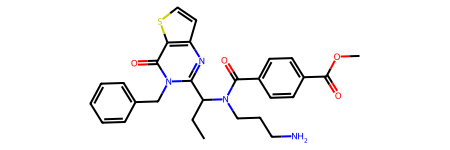

In [144]:
Chem.MolFromSmiles(valid_smiles[10])

In [145]:
torch.manual_seed(1)
smiles = sample(finetunemodel, starting_str="C", scale_factor=0.5, max_length=1000)

100%|██████████████████████████████████████| 1000/1000 [00:06<00:00, 157.16it/s]


In [146]:
list_of_smiles = []

for smiles in smiles.split("\n"):
    list_of_smiles.append(smiles)

In [147]:

from rdkit import Chem
valid_smiles = []

for smi in list_of_smiles:
    mol = Chem.MolFromSmiles(smi)
    if mol:
        valid_smiles.append(smi)
    else:
        pass
        #print(f"Invalid SMILES string: {smi}")


# Replace with actual data

accuracy = (len(valid_smiles) / len(list_of_smiles) ) * 100
print(f"Accuracy = {len(valid_smiles)}/{len(list_of_smiles)} = {accuracy:.2f}")


Accuracy = 5/25 = 20.00


[16:21:02] SMILES Parse Error: syntax error while parsing: C@H]1c1cccc(O)c1
[16:21:02] SMILES Parse Error: Failed parsing SMILES 'C@H]1c1cccc(O)c1' for input: 'C@H]1c1cccc(O)c1'
[16:21:02] Can't kekulize mol.  Unkekulized atoms: 31
[16:21:02] SMILES Parse Error: extra close parentheses while parsing: CCOC(=O)C12c3ccccc3O2)cc1
[16:21:02] SMILES Parse Error: Failed parsing SMILES 'CCOC(=O)C12c3ccccc3O2)cc1' for input: 'CCOC(=O)C12c3ccccc3O2)cc1'
[16:21:02] SMILES Parse Error: syntax error while parsing: CC]1C(=O)NCCc2c([nH]c3ccccc23)C1c1cccc(Cl)c1)N2
[16:21:02] SMILES Parse Error: Failed parsing SMILES 'CC]1C(=O)NCCc2c([nH]c3ccccc23)C1c1cccc(Cl)c1)N2' for input: 'CC]1C(=O)NCCc2c([nH]c3ccccc23)C1c1cccc(Cl)c1)N2'
[16:21:02] SMILES Parse Error: extra close parentheses while parsing: CC(=O)C1=NN(c2c=c3ccc(Cl)cc3)S2)SC1(C)c1ccccc1
[16:21:02] SMILES Parse Error: Failed parsing SMILES 'CC(=O)C1=NN(c2c=c3ccc(Cl)cc3)S2)SC1(C)c1ccccc1' for input: 'CC(=O)C1=NN(c2c=c3ccc(Cl)cc3)S2)SC1(C)c1ccccc1'
[1

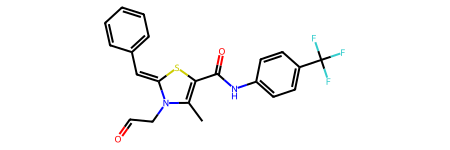

In [149]:
Chem.MolFromSmiles(valid_smiles[4])

As we can see, the results are coherent with our hypothesis. We can choose to generate correct text with less novelty or create diverse text with mroe randomness. It is a trade-off.

# Reinforcement Learning


In [5]:
import torch.nn as nn
import torch
class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size):
        super().__init__()
        self.rnn_hidden_size = rnn_hidden_size
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.LSTM(embed_dim, rnn_hidden_size, batch_first=True)
        self.fc = nn.Linear(rnn_hidden_size, vocab_size)

    def forward(self, x, hidden, cell):
        out = self.embedding(x).unsqueeze(1)
        out, (hidden, cell) = self.rnn(out, (hidden, cell))
        out = self.fc(out).reshape(out.size(0), -1)
        return out, hidden, cell

    def init_hidden(self, batch_size):
        hidden = torch.zeros(1, batch_size, self.rnn_hidden_size)
        cell = torch.zeros(1, batch_size, self.rnn_hidden_size)
        return hidden, cell

In [6]:
# Create RNN model
vocab_size = 31
embed_dim = 256
rnn_hidden_size = 512
torch.manual_seed(1)
finetunemodel = RNN(vocab_size, embed_dim, rnn_hidden_size)
finetunemodel


RNN(
  (embedding): Embedding(31, 256)
  (rnn): LSTM(256, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=31, bias=True)
)

In [21]:
from tqdm import tqdm
device = "mps" if torch.backends.mps.is_available() else "cpu"

finetunemodel.load_state_dict(torch.load("finetunedmodel.pt"))


<All keys matched successfully>

In [22]:
finetunemodel.to(device)

RNN(
  (embedding): Embedding(31, 256)
  (rnn): LSTM(256, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=31, bias=True)
)

In [23]:
import torch
from torch.distributions.categorical import Categorical
from tqdm import tqdm

device = "mps" if torch.backends.mps.is_available() else "cpu"

def sample(model, starting_str, max_length=100, scale_factor=1.0):
    encoded_input = torch.tensor([char2int[s] for s in starting_str])
    encoded_input = torch.reshape(encoded_input, (1, -1))
    generated_str = starting_str
    log_probs = []

    model.eval()
    hidden, cell = model.init_hidden(batch_size=1)
    hidden = hidden.to(device)
    encoded_input = encoded_input.to(device)
    cell = cell.to(device)
    for c in range(len(starting_str) - 1):
        _, hidden, cell = model(encoded_input[:, c].view(1), hidden, cell)
    last_char = encoded_input[:, -1]
    for i in range(max_length):
        logits, hidden, cell = model(last_char.view(1), hidden, cell)
        logits = torch.squeeze(logits, 0)
        scaled_logits = logits * scale_factor
        m = Categorical(logits=scaled_logits)
        last_char = m.sample()
        log_probs.append(m.log_prob(last_char))
        generated_str += str(char_array[last_char])

        if i % 10 == 0:
            torch.mps.empty_cache()

    return generated_str, log_probs

torch.manual_seed(1)
#finetunedsmiles, log_probs = sample(finetunemodel, starting_str="C", scale_factor=0.5)


In [25]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from rdkit import Chem
from rdkit import RDLogger

# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')
# Reward function to incentivize 2 to 3 chlorine atoms
def reward_function(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return -1  # Penalize invalid SMILES
        num_cl = sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() == 'Cl')
        if 2 <= num_cl <= 3:
            return 1  # Reward if 2 to 3 Cl atoms
        else:
            return -1  # Penalize otherwise
    except:
        return -1  # Penalize if RDKit fails to parse

# Initialize your LSTM model, optimizer, and other hyperparameters
model = finetunemodel.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_episodes = 1000
batch_size = 5
starting_str = "C"

for episode in tqdm(range(num_episodes)):
    total_loss = 0
    for _ in tqdm(range(batch_size)):
        generated_smiles, log_probs = sample(model, starting_str, scale_factor=1.0)
        reward = reward_function(generated_smiles)
        
        # Compute the policy gradient
        loss = -sum(log_probs) * reward
        total_loss += loss
    
    # Normalize total_loss by batch_size
    total_loss /= batch_size

    # Update the model
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if episode % 2 == 0:
        print(f"Episode {episode}, Average Reward: {total_loss.item() / batch_size}")


  0%|                                          | 1/1000 [00:03<55:10,  3.31s/it]

Episode 0, Average Reward: -4.701010131835938



  0%|▏                                         | 3/1000 [00:09<52:39,  3.17s/it]

Episode 2, Average Reward: -5.205728912353516



  0%|▏                                         | 5/1000 [00:15<52:10,  3.15s/it]

Episode 4, Average Reward: -5.611130905151367



  1%|▎                                         | 7/1000 [00:22<51:59,  3.14s/it]

Episode 6, Average Reward: -6.258908081054687



  1%|▍                                         | 9/1000 [00:28<51:22,  3.11s/it]

Episode 8, Average Reward: -6.0145008087158205



  1%|▍                                        | 11/1000 [00:34<50:35,  3.07s/it]

Episode 10, Average Reward: -5.502204513549804



  1%|▌                                        | 13/1000 [00:40<50:23,  3.06s/it]

Episode 12, Average Reward: -4.128024673461914



  2%|▌                                        | 15/1000 [00:46<50:13,  3.06s/it]

Episode 14, Average Reward: -5.140709304809571



  2%|▋                                        | 17/1000 [00:52<50:46,  3.10s/it]

Episode 16, Average Reward: -5.4303955078125



  2%|▊                                        | 19/1000 [00:58<49:36,  3.03s/it]

Episode 18, Average Reward: -7.750245666503906



  2%|▊                                        | 21/1000 [01:05<51:08,  3.13s/it]

Episode 20, Average Reward: -5.285308837890625



  2%|▉                                        | 23/1000 [01:11<51:25,  3.16s/it]

Episode 22, Average Reward: -5.639557647705078



  2%|█                                        | 25/1000 [01:17<50:50,  3.13s/it]

Episode 24, Average Reward: -7.733406066894531



  3%|█                                        | 27/1000 [01:24<50:20,  3.10s/it]

Episode 26, Average Reward: -5.900902557373047



  3%|█▏                                       | 29/1000 [01:30<49:52,  3.08s/it]

Episode 28, Average Reward: -6.878558349609375



  3%|█▎                                       | 31/1000 [01:36<49:24,  3.06s/it]

Episode 30, Average Reward: -5.5170238494873045



  3%|█▎                                       | 33/1000 [01:42<49:17,  3.06s/it]

Episode 32, Average Reward: -5.2037403106689455



  4%|█▍                                       | 35/1000 [01:48<49:18,  3.07s/it]

Episode 34, Average Reward: -6.382920455932617



  4%|█▌                                       | 37/1000 [01:54<49:48,  3.10s/it]

Episode 36, Average Reward: -5.60723648071289



  4%|█▌                                       | 39/1000 [02:01<51:28,  3.21s/it]

Episode 38, Average Reward: -7.191105651855469



  4%|█▋                                       | 41/1000 [02:08<52:18,  3.27s/it]

Episode 40, Average Reward: -6.892851257324219



  4%|█▊                                       | 43/1000 [02:14<52:04,  3.26s/it]

Episode 42, Average Reward: -7.268515777587891



  4%|█▊                                       | 45/1000 [02:21<52:25,  3.29s/it]

Episode 44, Average Reward: -7.110451507568359



  5%|█▉                                       | 47/1000 [02:27<51:34,  3.25s/it]

Episode 46, Average Reward: -6.927763366699219



  5%|██                                       | 49/1000 [02:33<49:48,  3.14s/it]

Episode 48, Average Reward: -7.314186859130859



  5%|██                                       | 51/1000 [02:39<48:57,  3.09s/it]

Episode 50, Average Reward: -6.699024200439453



  5%|██▏                                      | 53/1000 [02:46<49:02,  3.11s/it]

Episode 52, Average Reward: -5.803364944458008



  6%|██▎                                      | 55/1000 [02:53<51:47,  3.29s/it]

Episode 54, Average Reward: -7.042015075683594



  6%|██▎                                      | 57/1000 [02:59<51:41,  3.29s/it]

Episode 56, Average Reward: -6.116763305664063



  6%|██▍                                      | 59/1000 [03:05<49:42,  3.17s/it]

Episode 58, Average Reward: -8.120005798339843



  6%|██▌                                      | 61/1000 [03:11<48:22,  3.09s/it]

Episode 60, Average Reward: -5.409908294677734



  6%|██▌                                      | 63/1000 [03:18<48:59,  3.14s/it]

Episode 62, Average Reward: -7.077970886230469



  6%|██▋                                      | 65/1000 [03:24<48:17,  3.10s/it]

Episode 64, Average Reward: -6.717774963378906



  7%|██▋                                      | 67/1000 [03:30<48:01,  3.09s/it]

Episode 66, Average Reward: -5.228572845458984



  7%|██▊                                      | 69/1000 [03:36<47:12,  3.04s/it]

Episode 68, Average Reward: -5.309299468994141



  7%|██▊                                      | 69/1000 [03:39<49:21,  3.18s/it]


RuntimeError: MPS backend out of memory (MPS allocated: 136.00 MB, other allocations: 8.94 GB, max allowed: 9.07 GB). Tried to allocate 4.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [17]:
import numpy as np
from rdkit import Chem

# Function to count the number of chlorine atoms in a SMILES string
def count_chlorine_atoms(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return 0  # Invalid SMILES
        return sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() == 'Cl')
    except:
        return 0  # Invalid SMILES

# Function to evaluate model efficiency
def evaluate_model(model, starting_str, num_samples=100, scale_factor=0.5):
    valid_smiles_count = 0
    desired_smiles_count = 0

    for _ in tqdm(range(num_samples)):
        generated_smiles, _ = sample(model, starting_str, scale_factor=scale_factor)
        if Chem.MolFromSmiles(generated_smiles) is not None:
            valid_smiles_count += 1
            if 2 <= count_chlorine_atoms(generated_smiles) <= 3:
                desired_smiles_count += 1

    valid_smiles_ratio = valid_smiles_count / num_samples
    desired_smiles_ratio = desired_smiles_count / num_samples

    print(f"Total SMILES Generated: {num_samples}")
    print(f"Valid SMILES Ratio: {valid_smiles_ratio:.2f}")
    print(f"Desired SMILES Ratio (2-3 Cl atoms): {desired_smiles_ratio:.2f}")

    return valid_smiles_ratio, desired_smiles_ratio



In [18]:
# Example usage
torch.manual_seed(1)
valid_smiles_ratio, desired_smiles_ratio = evaluate_model(finetunemodel, starting_str="C", num_samples=1000, scale_factor=0.5)


  0%|                                                  | 0/1000 [00:00<?, ?it/s][19:47:27] SMILES Parse Error: extra close parentheses while parsing: C(=N)/[C@@H](O)C(=O)N1Cc2ccc(Cl)cc2)C(=O)c1ccccco1
CCOC(=O)C1Cc2ccccnc2nsc(C)(c2cccc(C)cc1)ncc(=O)nnc
[19:47:27] SMILES Parse Error: Failed parsing SMILES 'C(=N)/[C@@H](O)C(=O)N1Cc2ccc(Cl)cc2)C(=O)c1ccccco1
CCOC(=O)C1Cc2ccccnc2nsc(C)(c2cccc(C)cc1)ncc(=O)nnc' for input: 'C(=N)/[C@@H](O)C(=O)N1Cc2ccc(Cl)cc2)C(=O)c1ccccco1
CCOC(=O)C1Cc2ccccnc2nsc(C)(c2cccc(C)cc1)ncc(=O)nnc'
  0%|                                          | 1/1000 [00:00<14:48,  1.12it/s][19:47:28] SMILES Parse Error: extra close parentheses while parsing: C)c1ccc2cc(Nc3ccc(F)ccc(Br)ncc3ccncc1)[nH]nc1nccnc2)ncc1-c]ccc(F)cc1)(F)(F)F)n1c(Nc(cccccHnc2ccccc2c1
[19:47:28] SMILES Parse Error: Failed parsing SMILES 'C)c1ccc2cc(Nc3ccc(F)ccc(Br)ncc3ccncc1)[nH]nc1nccnc2)ncc1-c]ccc(F)cc1)(F)(F)F)n1c(Nc(cccccHnc2ccccc2c1' for input: 'C)c1ccc2cc(Nc3ccc(F)ccc(Br)ncc3ccncc1)[nH]nc1nccnc2)ncc

Total SMILES Generated: 1000
Valid SMILES Ratio: 0.04
Desired SMILES Ratio (2-3 Cl atoms): 0.00


In [23]:
torch.save(finetunemodel.state_dict(), "finetunedmodel_RL.pt")

In [19]:
valid_smiles_ratio

0.035

In [20]:
desired_smiles_ratio

0.0